In [1]:
%tensorflow_version 1.x
import tensorflow as tf

# Download the code
!git clone https://github.com/NVlabs/stylegan2.git
%cd stylegan2
!nvcc test_nvcc.cu -o test_nvcc -run

print('Tensorflow version: {}'.format(tf.__version__) )
!nvidia-smi -L
print('GPU Identified at: {}'.format(tf.test.gpu_device_name()))

TensorFlow 1.x selected.
Cloning into 'stylegan2'...
remote: Enumerating objects: 122, done.
remote: Total 122 (delta 0), reused 0 (delta 0), pack-reused 122
Receiving objects: 100% (122/122), 590.61 KiB | 36.91 MiB/s, done.
Resolving deltas: 100% (55/55), done.
/content/stylegan2
CPU says hello.
GPU says hello.
Tensorflow version: 1.15.2
GPU 0: Tesla T4 (UUID: GPU-d754bfff-448d-111f-9442-baf6aedf1639)
GPU Identified at: /device:GPU:0


In [2]:
# 直接使用示例
# !python run_generator.py generate-images --network=gdrive:networks/stylegan2-ffhq-config-f.pkl \
#   --seeds=6600-6625 --truncation-psi=0.5

In [3]:
!git clone https://github.com/NVlabs/stylegan2.git

Cloning into 'stylegan2'...
remote: Enumerating objects: 122, done.
remote: Total 122 (delta 0), reused 0 (delta 0), pack-reused 122
Receiving objects: 100% (122/122), 590.61 KiB | 22.71 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [4]:
%cd /content/stylegan2

/content/stylegan2


In [5]:
!pip install tqdm

In [6]:
import pretrained_networks
network_pkl = 'gdrive:networks/stylegan2-ffhq-config-f.pkl'
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


In [7]:
import dnnlib
import dnnlib.tflib as tflib
import PIL.Image
from tqdm import tqdm
import numpy as np

def generate_zs_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
    return zs  # array([1,512])

def generate_images(zs, truncation_psi, path=None):
    imgs = []
    noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if not isinstance(truncation_psi, list):
        truncation_psi = [truncation_psi] * len(zs)
        
    for z_idx, z in tqdm(enumerate(zs)):
        Gs_kwargs.truncation_psi = truncation_psi[z_idx]
        noise_rnd = np.random.RandomState(1) # fix noise
        tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
        img = PIL.Image.fromarray(images[0], 'RGB')
        if path:
          img.save(path+f"image{z_idx}.png")
        imgs.append(img)
    return imgs

def generate_images_from_seeds(seeds, truncation_psi):
    return generate_images(generate_zs_from_seeds(seeds), truncation_psi)

In [8]:
from math import ceil

def createImageGrid(images, scale=0.25, rows=1):
   w,h = images[0].size
   w = int(w*scale)
   h = int(h*scale)
   height = rows*h
   cols = ceil(len(images) / rows)
   width = cols*w
   canvas = PIL.Image.new('RGBA', (width,height), 'white')
   for i,img in enumerate(images):
     img = img.resize((w,h), PIL.Image.ANTIALIAS)
     canvas.paste(img, (w*(i % cols), h*(i // cols))) 
   return canvas

In [9]:
# 插值方法一
def interpolate(zs, steps):
   out = []
   for i in range(len(zs)-1):
    for index in range(steps):
     fraction = index/float(steps) 
     out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
   return out

In [10]:
# 插值方法二
def interpolate2(zs,steps):
  out = []
  for i in range(len(zs)-1):
    v1 = zs[0]
    v2 = zs[1]
    diff = v2 - v1
    step = diff / steps
    current = v1.copy()
    for j in range(steps):
      current = current + step
      out.append(current)
  return out

In [11]:
seeds = np.random.randint(10000000, size=2)
zs = generate_zs_from_seeds(seeds)
# print(len(zs))
# zs1 = interpolate(zs, 10)
# print(len(zs1))
# zs2 = interpolate2(zs, 10)
# print(len(zs2))

In [12]:
print(seeds)

[4275380 4745059]


10it [00:12,  1.22s/it]


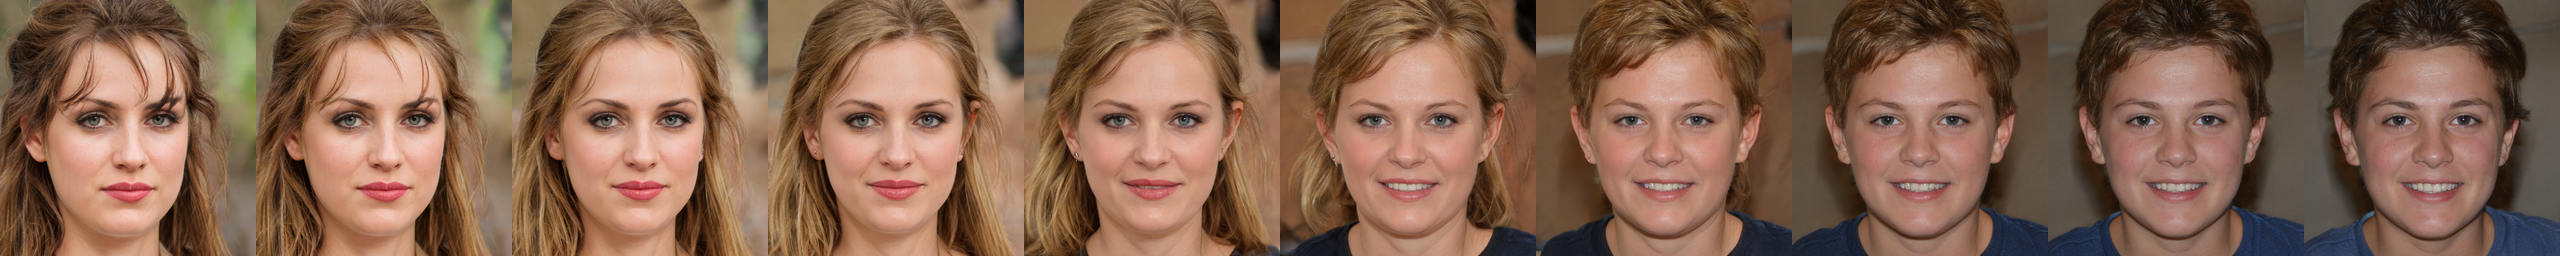

In [13]:
# 第一种插值方法的结果
createImageGrid(generate_images(interpolate(zs, 10), 0.5))

10it [00:02,  4.66it/s]


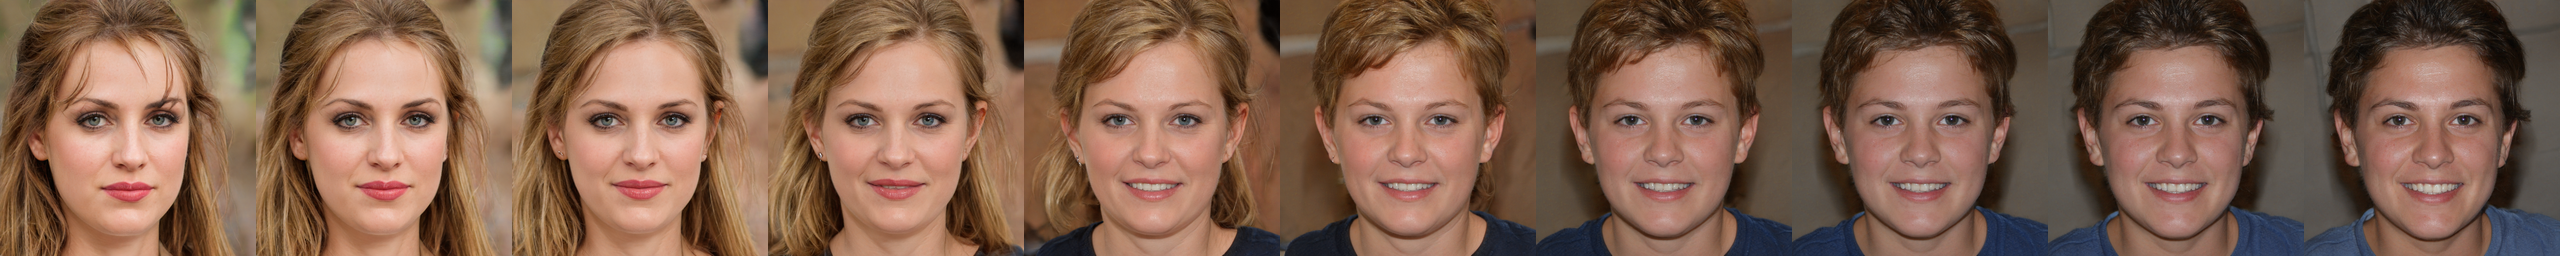

In [14]:
# 第二种插值方法的结果
createImageGrid(generate_images(interpolate2(zs, 10), 0.5))

In [15]:
from IPython import display as ipythondisplay
import io
import os
import base64
from IPython.display import HTML

def show_video(vid):
  #mp4list = [video
  #if len(mp4list) > 0:
  ext = os.path.splitext(vid)[-1][1:]
  video = io.open(vid, 'r+b').read()
  #encoded = base64.b64encode(video)
  ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
              loop controls style="height: 400px;">
              <source src="data:video/{1}';base64,{0}" type="video/{1}" />
              </video>'''.format(base64.b64encode(video).decode('ascii'), ext)))


In [16]:

import cv2
from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
import os
from subprocess import call
 
img_root = '/content/results/'
out_root = '/content/video.avi'

def save_imgs_to_video(img_root,out_root,fps=30,size=(512,512)):
  fourcc = VideoWriter_fourcc(*"MJPG")  #支持jpg
  videoWriter = cv2.VideoWriter(out_root, fourcc, fps, size)
  im_names = os.listdir(img_root)
  print(len(im_names))
  for im_name in tqdm(range(len(im_names))):
      string = img_root + 'image' + str(im_name) + '.png'
      frame = cv2.imread(string)
      frame = cv2.resize(frame, size)   #注意这里resize大小要和视频的一样
      videoWriter.write(frame)
  videoWriter.release()

  # dir = out_root.strip(".avi")
  # command = "ffmpeg -i %s.avi %s.mp4" % (dir, dir)   #使用ffmped将avi压缩为mp4,注意两个的路径
  # call(command.split())

In [17]:
# Remove any prior results
!rm /content/results/* 
import os 
from tqdm.notebook import tqdm

os.makedirs("/content/results/", exist_ok=True)

path = f"/content/results/"



rm: cannot remove '/content/results/*': No such file or directory


In [ ]:
img_root = '/content/results/'
out_root1 = '/content/video1.avi'
generate_images(interpolate(zs, 300) ,0.7,path=path)
save_imgs_to_video(img_root,out_root1)


In [ ]:
out_root2 = '/content/video2.avi'
generate_images(interpolate2(zs, 300),0.5,path=path)
save_imgs_to_video(img_root,out_root2)


In [ ]:
# 下载视频
# from google.colab import files
# files.download(out_root1)
# files.download(out_root2)
